<a href="https://colab.research.google.com/github/apothula/dl/blob/main/ObjectDetection/01_Inference_Tensorflow_Hub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="font-size:30px;">Introduction to Tensorflow Hub</h1>

In this notebook, we will provide inferences from a few object models from Tensorflow Hub.

First, we will see what Tensorflow Hub is. Then we will load a SSD model from a  wide variety of [object detection models](https://tfhub.dev/tensorflow/collections/object_detection/1) (trained on COCO 2017 dataset) using the Tensorflow Hub and perform inference on some sample data.

<img src="https://opencv.org/wp-content/uploads/2022/05/c4-06-tensorflow-hub-feature-image.png" width="900">

## Table of Contents

* [1 Introduction to Tensorflow Hub](#1-Introduction-to-Tensorflow-Hub)
* [2 SSD model Inference using Tensorflow Hub](#2-SSD-model-Inference-using-Tensorflow-Hub)
* [3 References](#3-References)

## 1 Introduction to Tensorflow Hub

TensorFlow Hub is a repository of trained machine learning models ready for fine-tuning and deployable anywhere. We can reuse trained models like SSD, Faster R-CNN and Mask R-CNN with just a few lines of code. From image classification, text embeddings, audio, and video action recognition, TensorFlow Hub is a space where you can browse trained models and datasets from across the TensorFlow ecosystem. You can use Tensorflow Hub to:

- Find trained models for transfer learning to save time on training

- Publish your own models

- Deploy models on devices and in the browser

To learn more about the models across various domains, you can visit this link [here](https://tfhub.dev/).

**However, in this notebook, we shall only limit ourselves to inference for object detection.**

<img src="https://opencv.org/wp-content/uploads/2022/05/c4-06-tensorflow-hub-object-detection-image.png" width="700">

In [1]:
import os
import pathlib
import matplotlib
import matplotlib.pyplot as plt

import io
import numpy as np
from six import BytesIO
import cv2
from PIL import Image
from six.moves.urllib.request import urlopen

import tensorflow as tf
import tensorflow_hub as hub

### 1.1 Utilities and Helper Functions

`load_image_into_numpy_array()` is a helper function to load an image.

In [2]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
    path: the file path to the image

    Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
    """

    image = None
    if(path.startswith('http')):

        response = urlopen(path)
        image_data = response.read()
        image_data = BytesIO(image_data)
        image = Image.open(image_data)

    else:
        image_data = tf.io.gfile.GFile(path, 'rb').read()
        image = Image.open(BytesIO(image_data))

    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((1, im_height, im_width, 3)).astype(np.uint8)


`category_index` is a dictionary that maps all 80 classes in the MS-COCO dataset with thier associated class ids.

In [3]:
category_index =  \
{
         1: 'person',
         2: 'bicycle',
         3: 'car',
         4: 'motorcycle',
         5: 'airplane',
         6: 'bus',
         7: 'train',
         8: 'truck',
         9: 'boat',
         10: 'traffic light',
         11: 'fire hydrant',
         13: 'stop sign',
         14: 'parking meter',
         15: 'bench',
         16: 'bird',
         17: 'cat',
         18: 'dog',
         19: 'horse',
         20: 'sheep',
         21: 'cow',
         22: 'elephant',
         23: 'bear',
         24: 'zebra',
         25: 'giraffe',
         27: 'backpack',
         28: 'umbrella',
         31: 'handbag',
         32: 'tie',
         33: 'suitcase',
         34: 'frisbee',
         35: 'skis',
         36: 'snowboard',
         37: 'sports ball',
         38: 'kite',
         39: 'baseball bat',
         40: 'baseball glove',
         41: 'skateboard',
         42: 'surfboard',
         43: 'tennis racket',
         44: 'bottle',
         46: 'wine glass',
         47: 'cup',
         48: 'fork',
         49: 'knife',
         50: 'spoon',
         51: 'bowl',
         52: 'banana',
         53: 'apple',
         54: 'sandwich',
         55: 'orange',
         56: 'broccoli',
         57: 'carrot',
         58: 'hot dog',
         59: 'pizza',
         60: 'donut',
         61: 'cake',
         62: 'chair',
         63: 'couch',
         64: 'potted plant',
         65: 'bed',
         67: 'dining table',
         70: 'toilet',
         72: 'tv',
         73: 'laptop',
         74: 'mouse',
         75: 'remote',
         76: 'keyboard',
         77: 'cell phone',
         78: 'microwave',
         79: 'oven',
         80: 'toaster',
         81: 'sink',
         82: 'refrigerator',
         84: 'book',
         85: 'clock',
         86: 'vase',
         87: 'scissors',
         88: 'teddy bear',
         89: 'hair drier',
         90: 'toothbrush'

}

Finally, we will use `COLOR_IDS` to map each class with a unique RGB color.

In [4]:
R = np.array(np.arange(0, 256, 32))
G = np.roll(R, 2)
B = np.roll(R, 4)

COLOR_IDS = np.array(np.meshgrid(R, G, B)).T.reshape(-1, 3)

## 2 SSD Model Inference using Tensorflow Hub

Since this is the first notebook on object detection, we will use pre-trained models from Tensorflow Hub just for inference. We will discuss more about the model architectures and their training as we move further in the course.

The following code cell maps the various model names to Tensorflow Hub handle. In this notebook, we will be dealing with three sets of models: `SSD_Resnet (RetinaNet)`, `SSD_Mobilenet`, and `EfficientDet`.

Apart from this, we also provide the image URLs for some sample test images from the MS-COCO dataset on which we will perform inference on.

In [5]:
SSD_Resnet    = {'SSD ResNet50 V1 FPN 640x640 (RetinaNet50)'    : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_640x640/1',
                 'SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)'  : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_1024x1024/1',
                 'SSD ResNet101 V1 FPN 640x640 (RetinaNet101)'  : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_640x640/1',
                 'SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)': 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_1024x1024/1',
                 'SSD ResNet152 V1 FPN 640x640 (RetinaNet152)'  : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_640x640/1',
                 'SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)': 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_1024x1024/1'
                }

SSD_Mobilenet = {'SSD MobileNet v2 320x320'         : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2',
                 'SSD MobileNet V1 FPN 640x640'     : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v1/fpn_640x640/1',
                 'SSD MobileNet V2 FPNLite 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1',
                 'SSD MobileNet V2 FPNLite 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_640x640/1'
                }

EfficientDet  = {'EfficientDet D0 512x512'   : 'https://tfhub.dev/tensorflow/efficientdet/d0/1',
                 'EfficientDet D1 640x640'   : 'https://tfhub.dev/tensorflow/efficientdet/d1/1',
                 'EfficientDet D2 768x768'   : 'https://tfhub.dev/tensorflow/efficientdet/d2/1',
                 'EfficientDet D3 896x896'   : 'https://tfhub.dev/tensorflow/efficientdet/d3/1',
                 'EfficientDet D4 1024x1024' : 'https://tfhub.dev/tensorflow/efficientdet/d4/1',
                 'EfficientDet D5 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d5/1',
                 'EfficientDet D6 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d6/1',
                 'EfficientDet D7 1536x1536' : 'https://tfhub.dev/tensorflow/efficientdet/d7/1'
                }

image_urls   = ['http://images.cocodataset.org/test2017/000000550803.jpg',
                'http://images.cocodataset.org/test2017/000000004053.jpg',
                'http://images.cocodataset.org/test2017/000000426603.jpg',
                'http://images.cocodataset.org/val2017/000000007088.jpg'
               ]

### 2.1 Model Overview

In the following code cell, we will use the pre-trained models listed below:
- **SSD ResNet101 V1 FPN 640x640 (RetinaNet101)**
- **SSD MobileNet V1 FPN 640x640**
- **EfficientDet D1 640x640**

Each of these models is accessed by specifying the specific model name from the model family.

In [6]:
model_display_name_1 = 'SSD ResNet101 V1 FPN 640x640 (RetinaNet101)'
model_handle_1 = SSD_Resnet[model_display_name_1]

print('Selected model:'+ model_display_name_1)
print('Model Handle at TensorFlow Hub: {}'.format(model_handle_1))

model_display_name_2 = 'SSD MobileNet V1 FPN 640x640'
model_handle_2 = SSD_Mobilenet[model_display_name_2]

print('Selected model:'+ model_display_name_2)
print('Model Handle at TensorFlow Hub: {}'.format(model_handle_2))

model_display_name_3 = 'EfficientDet D1 640x640'
model_handle_3 = EfficientDet[model_display_name_3]

print('Selected model:'+ model_display_name_3)
print('Model Handle at TensorFlow Hub: {}'.format(model_handle_3))

Selected model:SSD ResNet101 V1 FPN 640x640 (RetinaNet101)
Model Handle at TensorFlow Hub: https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_640x640/1
Selected model:SSD MobileNet V1 FPN 640x640
Model Handle at TensorFlow Hub: https://tfhub.dev/tensorflow/ssd_mobilenet_v1/fpn_640x640/1
Selected model:EfficientDet D1 640x640
Model Handle at TensorFlow Hub: https://tfhub.dev/tensorflow/efficientdet/d1/1


### 2.2 Loading the Selected Model from TensorFlow Hub

Here we need the model handle that was selected and use the Tensorflow Hub library to load it to memory.

In [7]:
# Model: SSD ResNet101 V1 FPN 640x640.
print('loading model_1...')
hub_model_1 = hub.load(model_handle_1)
print('model_1 loaded!')

# Model: SSD MobileNet V1 FPN 640x640.
print('\nloading model_2...')
hub_model_2 = hub.load(model_handle_2)
print('model_2 loaded!')

# Model: EfficientDet D1 640x640.
print('\nloading model_3...')
hub_model_3 = hub.load(model_handle_3)
print('model_3 loaded!')

loading model_1...
model_1 loaded!

loading model_2...
model_2 loaded!

loading model_3...


model_3 loaded!


### 2.3 Load Sample Images

Let's try the model on some sample images.

**Note:** when using images with an alpha channel, the model expects 3 color channels and the alpha channel will count as a 4th.

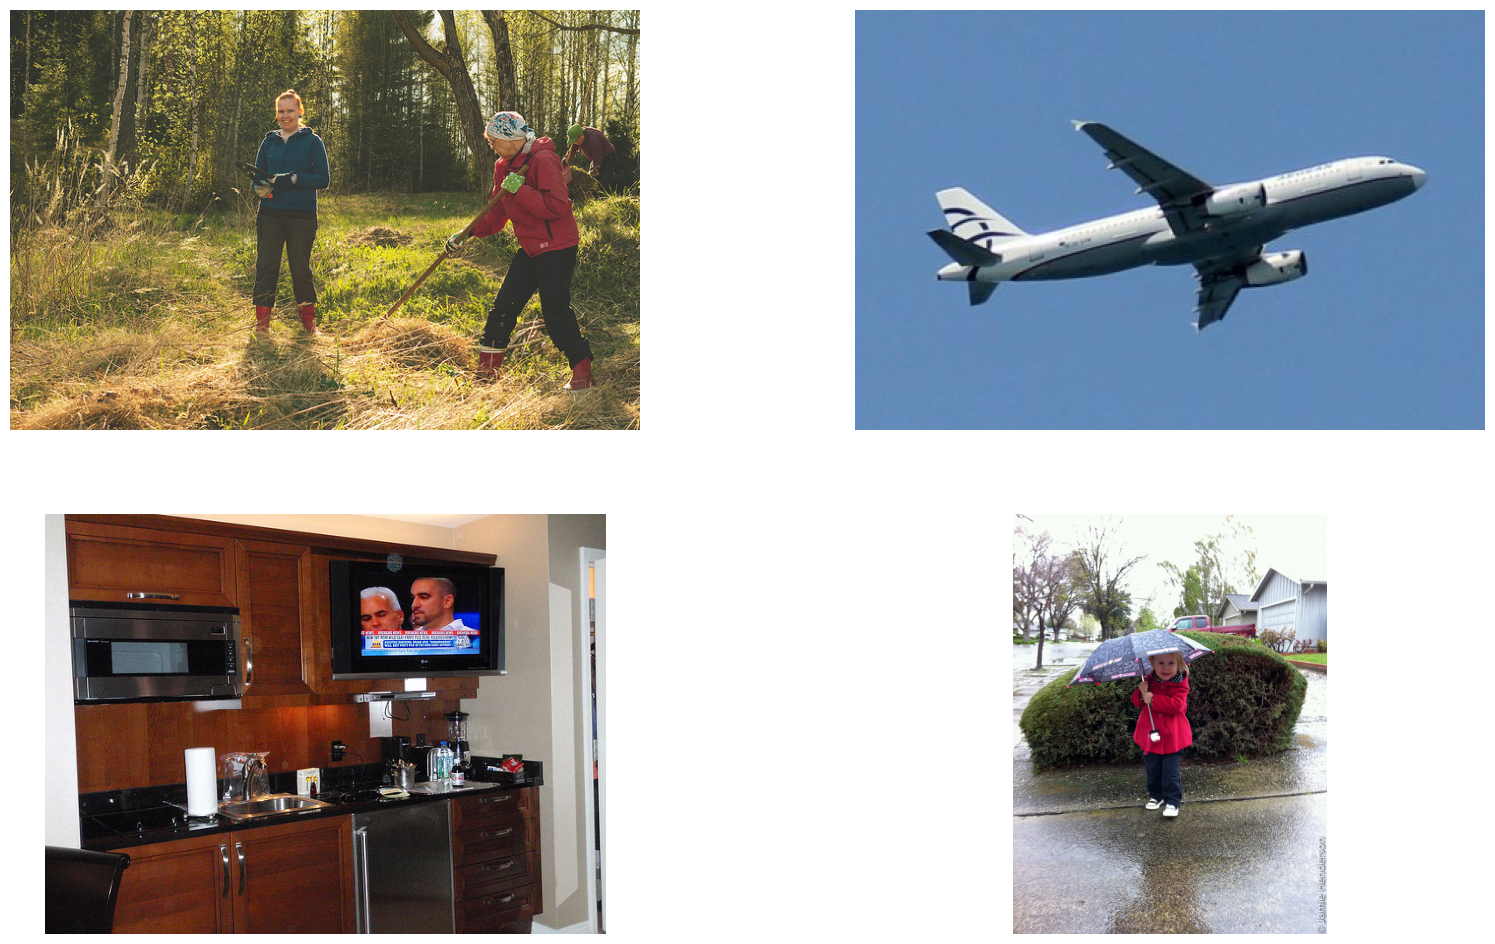

In [8]:
images = []
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))

idx=0
for axis in ax.flat:
    image_np = load_image_into_numpy_array(image_urls[idx])
    images.append(image_np)
    axis.imshow(image_np[0])
    axis.axis('off')
    idx+=1

plt.show(block=False)

### 2.4 Performance Inference

To perform inference, we define the function below which accepts a list of images and a pre-trained model.

In [9]:
# Running inference.
def run_inference(images, model):
    results_final= []
    for img in images:
        results = model(img)
        result = {key:value.numpy() for key,value in results.items()}

        results_final.append(result)

    return results_final

Now, let's use this function perform inference on the sample images using the three models we selected above.

In [10]:
# Inference from Resnet101.
results_final_1 = run_inference(images, hub_model_1)

In [11]:
# Inference from SSD MobileNet v1 with FPN.
results_final_2 = run_inference(images, hub_model_2)

In [12]:
# Inference from EffiecientDet D1.
results_final_3 = run_inference(images, hub_model_3)

In [13]:
# Print the dictionary keys from the results.
# This would be required to plot the detection boxes, the class labels along with their confidences.
print(results_final_1[0].keys())

dict_keys(['raw_detection_boxes', 'detection_boxes', 'detection_scores', 'detection_multiclass_scores', 'raw_detection_scores', 'num_detections', 'detection_classes', 'detection_anchor_indices'])


**Note:** The coordinates output by `detection_boxes` are given in normalized form (i.e., in the interval [0, 1]).

Documentation links are provided below for each of the models.

- https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_640x640/1

- https://tfhub.dev/tensorflow/ssd_mobilenet_v1/fpn_640x640/1

- https://tfhub.dev/tensorflow/efficientdet/d1/1

You can try out other object detection models located [here](https://tfhub.dev/tensorflow/collections/object_detection/1) and compare the results!

### 2.5 Visualizing the Results

We will use the following utility functions: `visualize_per_image` and `visualize_results` to display the bounding boxes from the inference step.

In the code below, you can set `min_score_thresh` to other values (between 0 and 1) to adjust the sensitivity of the detections that are rendered on the images.

In [14]:
def visualize_per_image(image, boxes, classes, scores, cat_id, min_score_thresh=.30):

    ids = np.where(scores >= min_score_thresh)[0]

    boxes_thres = boxes[ids]
    classes_thres = classes[ids]
    scores_thres = scores[ids]

    img_bbox = image.copy()
    im_height, im_width = image.shape[:2]

    for box, cls, score in zip(boxes_thres, classes_thres, scores_thres):

        ymin, xmin, ymax, xmax = box
        class_name = cat_id[cls]
        (left, right, top, bottom) = (int(xmin * im_width), int(xmax * im_width),  int(ymin * im_height), int(ymax * im_height))

        color = tuple(COLOR_IDS[cls % len(COLOR_IDS)].tolist())[::-1]

        img_bbox = cv2.rectangle(img_bbox, (left, top), (right, bottom), color, thickness=2)

        display_txt = '{}: {:.2f}%'.format(class_name, 100*score)

        ((text_width, text_height), _) = cv2.getTextSize(display_txt, cv2.FONT_HERSHEY_SIMPLEX, 1.0, 2)


        img_bbox = cv2.rectangle(img_bbox, (left, top - int(0.9 * text_height)), (left + int(0.4*text_width), top), color, thickness=-1)


        img_bbox = cv2.putText(img_bbox, display_txt,
                (left, top - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 0), 1)


    return img_bbox

In [15]:
def visualize_results(images, results_final, title):

    label_id_offset = 0

    plt.figure(figsize=[20, 12])
    plt.suptitle(title, fontsize=24)

    idx=0
    for idx, img_plt in enumerate(images):
        image_np_with_detections = img_plt.copy()
        image_bbox = visualize_per_image(
                image_np_with_detections[0],
                results_final[idx]['detection_boxes'][0],
                (results_final[idx]['detection_classes'][0]).astype(int),
                results_final[idx]['detection_scores'][0],
                category_index,
                min_score_thresh=.30,
                )

        plt.subplot(2,2,idx+1);
        plt.imshow(image_bbox)
        plt.axis('off')


    plt.show(block=False)

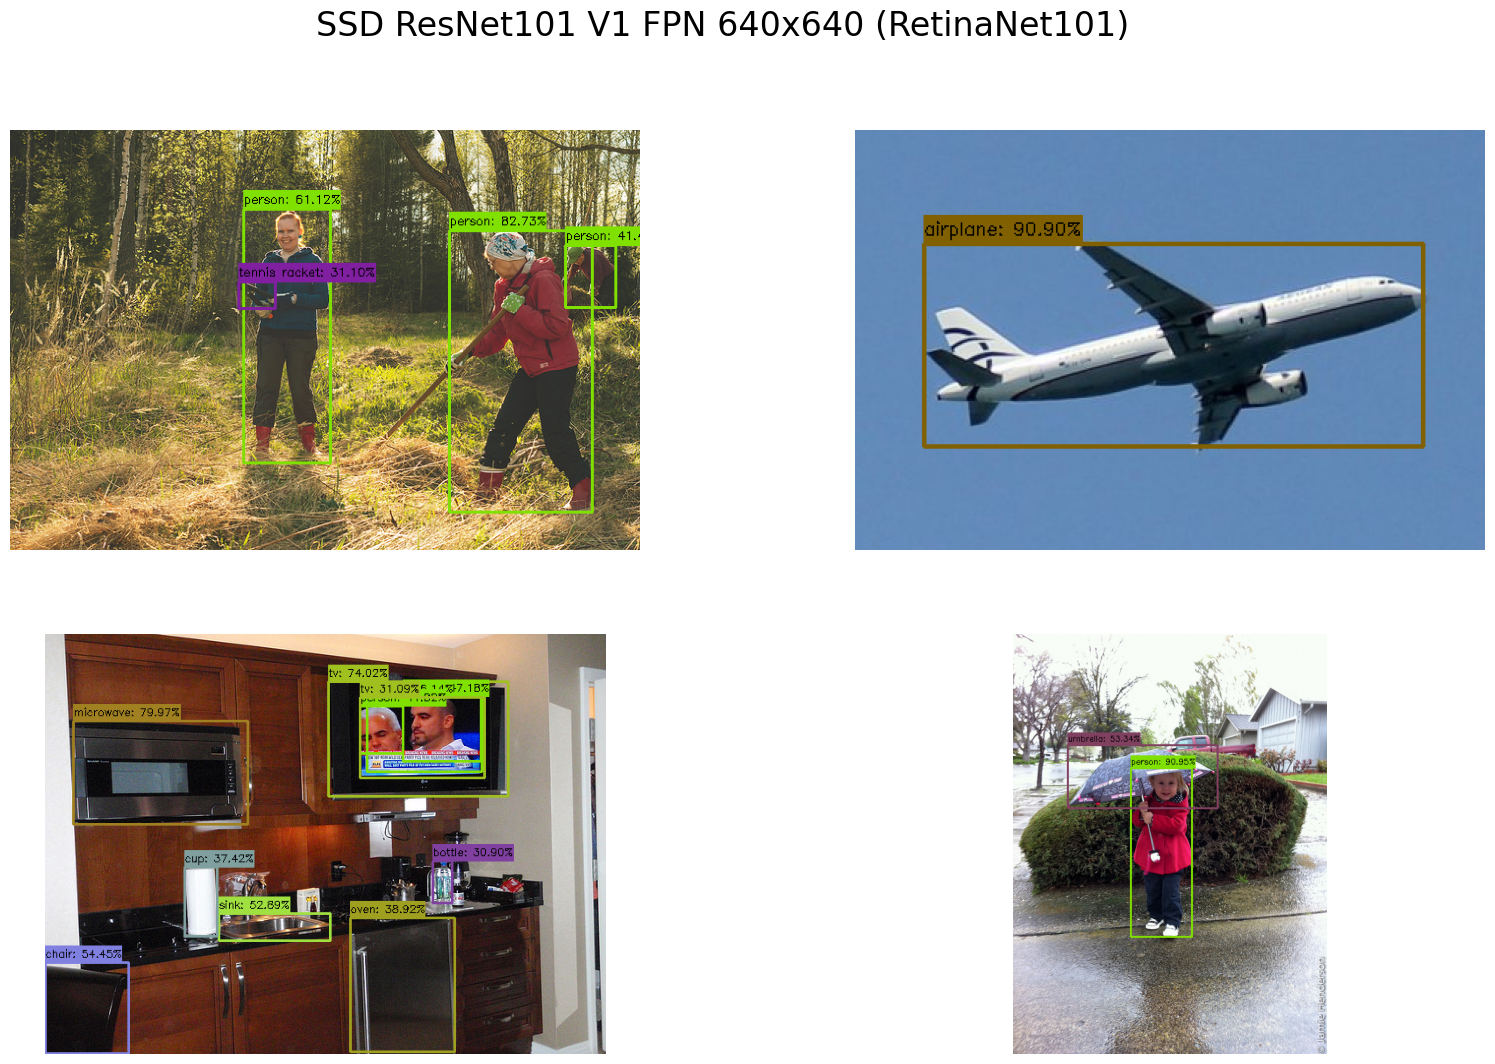

In [16]:
visualize_results(images, results_final_1, title = 'SSD ResNet101 V1 FPN 640x640 (RetinaNet101)')

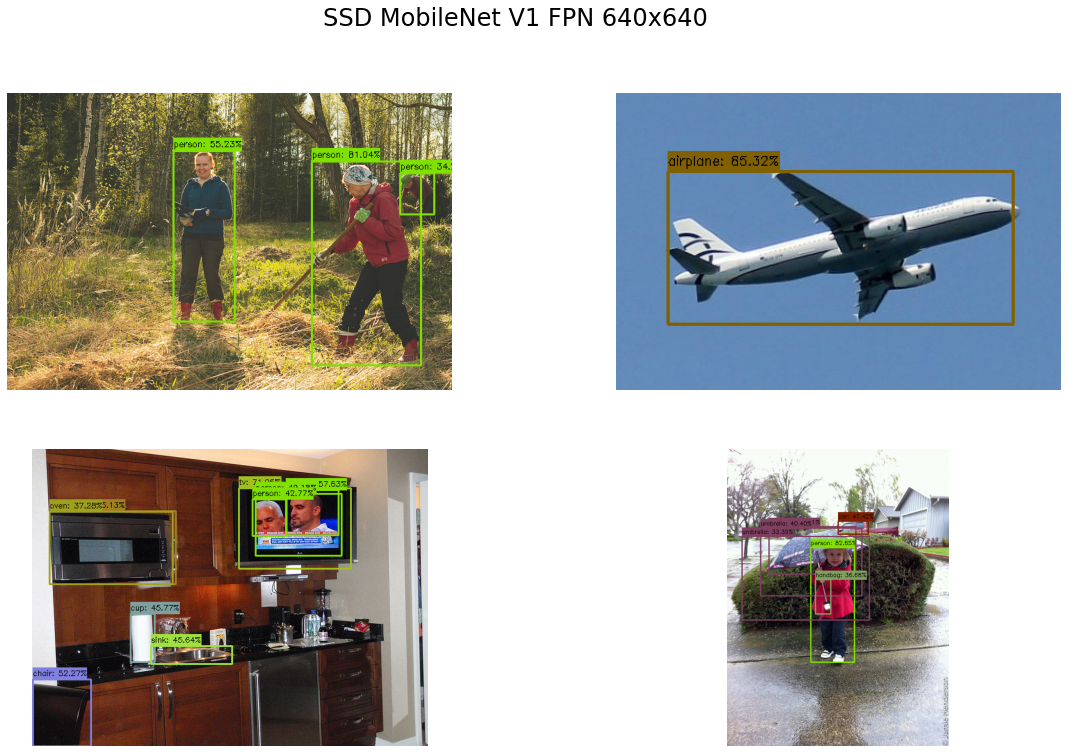

In [ ]:
visualize_results(images, results_final_2, title = 'SSD MobileNet V1 FPN 640x640')

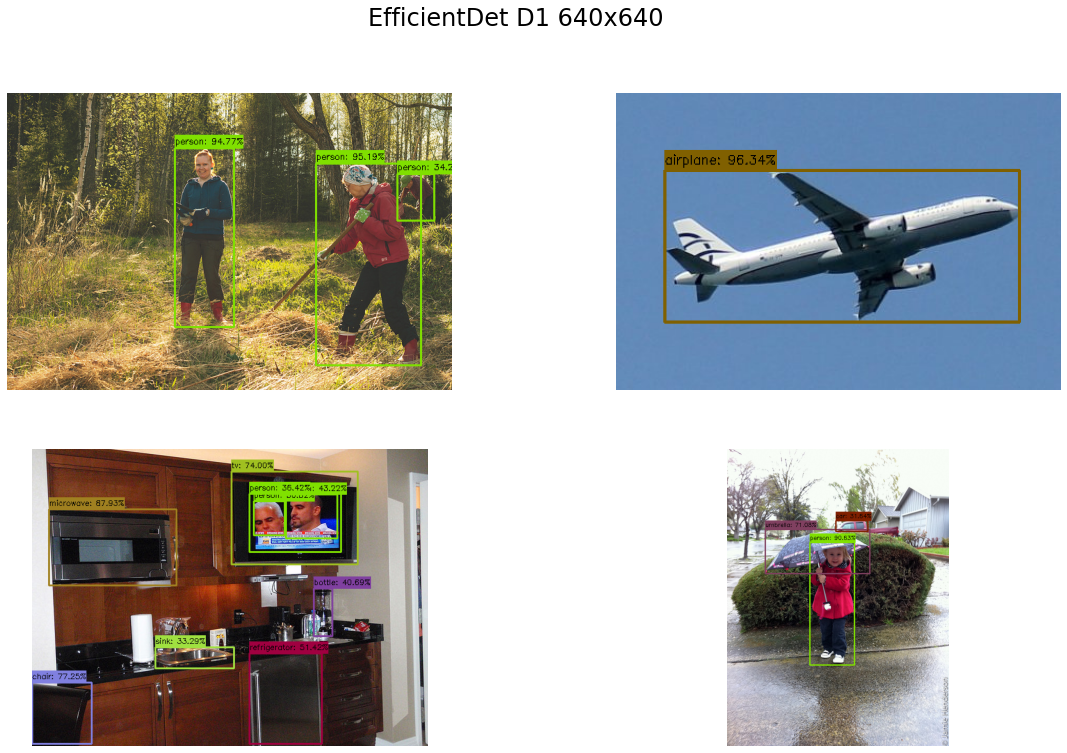

In [ ]:
visualize_results(images, results_final_3, title = 'EfficientDet D1 640x640')

From the above inference results, we can see that EfficientDet shows somewhat better results than MobileNet and ResNet; as there are false positives from both Resnet and MobileNet.

## 3 References

- [TensorFlow Hub Object Detection](https://www.tensorflow.org/hub/tutorials/tf2_object_detection)

- [Tensorflow Hub](https://www.tensorflow.org/hub)

- [Publishing models](https://www.tensorflow.org/hub/publish)
